# This is a notebook that shows how to produce Grad-CAM visualizations for ALBEF

# 1. Set the paths for model checkpoint and configuration

In [1]:
model_path = 'D://ALBEF_dir//refcoco.pth'
bert_config_path = 'configs/config_bert.json'
use_cuda = False

# 2. Model defination

In [2]:
from functools import partial
from models.vit import VisionTransformer
from models.xbert import BertConfig, BertModel
from models.tokenization_bert import BertTokenizer

import torch
from torch import nn
from torchvision import transforms

import json

class VL_Transformer_ITM(nn.Module):
    def __init__(self,                 
                 text_encoder = None,
                 config_bert = ''
                 ):
        super().__init__()
    
        bert_config = BertConfig.from_json_file(config_bert)

        self.visual_encoder = VisionTransformer(
            img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12, 
            mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6)) 

        self.text_encoder = BertModel.from_pretrained(text_encoder, config=bert_config, add_pooling_layer=False)   
        
        self.itm_head = nn.Linear(768, 2) 

        
    def forward(self, image, text):
        image_embeds = self.visual_encoder(image) 

        image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)

        output = self.text_encoder(text.input_ids, 
                                attention_mask = text.attention_mask,
                                encoder_hidden_states = image_embeds,
                                encoder_attention_mask = image_atts,      
                                return_dict = True,
                               )     
           
        vl_embeddings = output.last_hidden_state[:,0,:]
        vl_output = self.itm_head(vl_embeddings)   
        return vl_output

C:\Users\Hyunmin\Anaconda3\envs\albef\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3. Text Preprocessing

In [3]:
import re

def pre_caption(caption,max_words=30):
    caption = re.sub(
        r"([,.'!?\"()*#:;~])",
        '',
        caption.lower(),
    ).replace('-', ' ').replace('/', ' ')

    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n') 
    caption = caption.strip(' ')

    #truncate caption
    caption_words = caption.split(' ')
    if len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])            
    return caption

# 4. Image Preprocessing and Postpressing

In [6]:
from PIL import Image

import cv2
import numpy as np

from skimage import transform as skimage_transform
from scipy.ndimage import filters
from matplotlib import pyplot as plt

def getAttMap(img, attMap, blur = True, overlap = True):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    attMap = skimage_transform.resize(attMap, (img.shape[:2]), order = 3, mode = 'constant')
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.7).reshape(attMap.shape + (1,))*img + (attMap**0.7).reshape(attMap.shape+(1,)) * attMapV
    return attMap


normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

transform = transforms.Compose([
    transforms.Resize((384,384),interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    normalize,
])     

C:\Users\Hyunmin\Anaconda3\envs\albef\lib\site-packages\torchvision\transforms\transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


# 5. Load model and tokenizer

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = VL_Transformer_ITM(text_encoder='bert-base-uncased', config_bert=bert_config_path)

checkpoint = torch.load(model_path, map_location='cpu')              
msg = model.load_state_dict(checkpoint,strict=False)
model.eval()

block_num = 8

model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.save_attention = True

if use_cuda:
    model.cuda() 

Downloading: 100%|██████████| 232k/232k [00:00<00:00, 245kB/s]  
Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 60.1kB/s]
Downloading: 100%|██████████| 466k/466k [00:01<00:00, 249kB/s]  
Downloading: 100%|██████████| 440M/440M [00:51<00:00, 8.59MB/s] 


# 6. Load Image and Text

In [8]:
image_path = 'examples/image0.jpg'
image_pil = Image.open(image_path).convert('RGB')   
image = transform(image_pil).unsqueeze(0)  

caption = 'the woman is working on her computer at the desk'
text = pre_caption(caption)
text_input = tokenizer(text, return_tensors="pt")

if use_cuda:
    image = image.cuda()
    text_input = text_input.to(image.device)

# 7. Compute GradCAM

In [9]:
output = model(image, text_input)
loss = output[:,1].sum()

model.zero_grad()
loss.backward()    

with torch.no_grad():
    mask = text_input.attention_mask.view(text_input.attention_mask.size(0),1,-1,1,1)

    grads=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attn_gradients()
    cams=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attention_map()

    cams = cams[:, :, :, 1:].reshape(image.size(0), 12, -1, 24, 24) * mask
    grads = grads[:, :, :, 1:].clamp(0).reshape(image.size(0), 12, -1, 24, 24) * mask

    gradcam = cams * grads
    gradcam = gradcam[0].mean(0).cpu().detach()

# 8. Visualize GradCam for each word

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


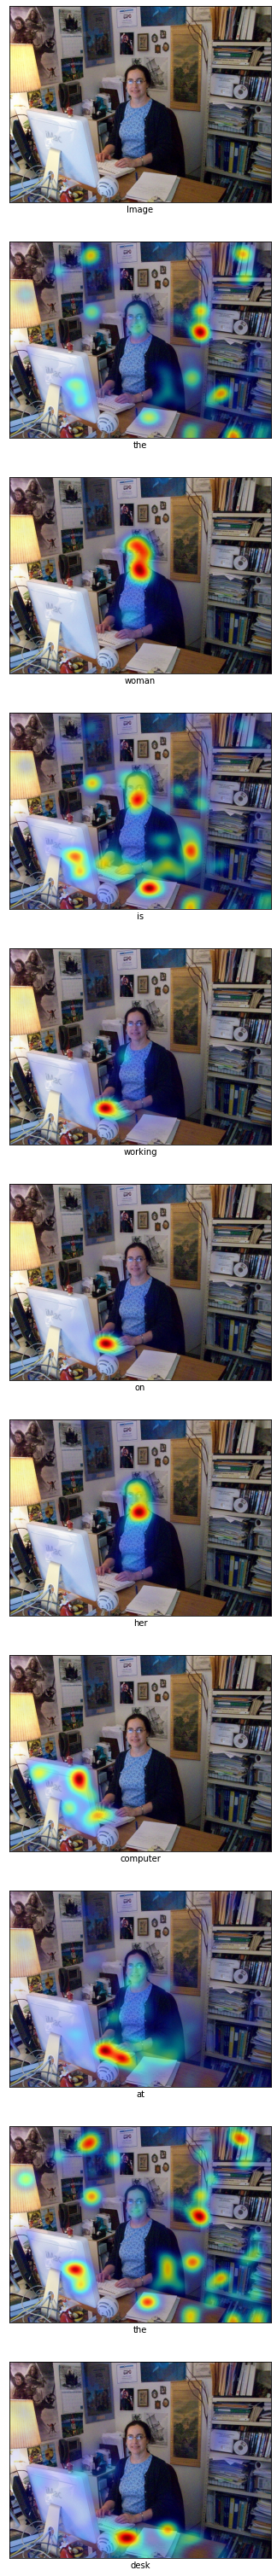

In [10]:
num_image = len(text_input.input_ids[0]) 
fig, ax = plt.subplots(num_image, 1, figsize=(15,5*num_image))

rgb_image = cv2.imread(image_path)[:, :, ::-1]
rgb_image = np.float32(rgb_image) / 255

ax[0].imshow(rgb_image)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel("Image")
            
for i,token_id in enumerate(text_input.input_ids[0][1:]):
    word = tokenizer.decode([token_id])
    gradcam_image = getAttMap(rgb_image, gradcam[i+1])
    ax[i+1].imshow(gradcam_image)
    ax[i+1].set_yticks([])
    ax[i+1].set_xticks([])
    ax[i+1].set_xlabel(word)